<a href="https://colab.research.google.com/github/Volviane/Reinforcement-learning/blob/master/Practical_Session_Fitted_Q_Iteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Google Colab setup

In [0]:
!pip install gym > /dev/null 2>&1

In [2]:
!git clone https://github.com/rlgammazero/mvarl_hands_on.git > /dev/null 2>&1
!cd mvarl_hands_on && git pull

Already up to date.


In [0]:
import sys
sys.path.insert(0, './mvarl_hands_on/fitted_q_iteration')

# Fitted Q Iteration (FQI)

We saw that, if $Q$ is the optimal value function, then it is the fixed point of the Bellman optimality operator

$$
Q(s, a) = T^*Q(s, a) = r(s, a) + \gamma \mathbb{E}_{s'\sim p(\cdot|s,a)}[\max_{a'}Q(s', a')]
$$
and can be found by value iteration: if $Q_{k+1} = T^* Q_{k}$, then $Q_k \to Q^*$.


The goal of Fitted Q Iteration (FQI) is to search for an approximation of $Q$ in a function space $\mathcal{F}$. It proceeds as value iteration but, instead of computing $T^* Q_{k}$ exactly, it looks for its best approximation in $\mathcal{F}$

$$
Q_{k+1} = \arg\min_{f \in \mathcal{F}} \mathbb{E}_{s, a \sim \mu}[ (f(s, a) - T^*Q_{k}(s,a))^2]
$$
where $\mu$ is some probability distribution on the state-action space. In practice, we cannot compute expectations exactly, and we consider the following approximation based on sampling:

$$
Q_{k+1} = \arg\min_{f \in \mathcal{F}} \sum_{i=1}^N [f(s_i, a_i) - (r_i + \gamma\max_{a'}Q_{k}(s'_i,a'))]^2
$$
for $s_i, a_i \sim \mu$ and $s'_i \in p(\cdot|s_i,a_i)$.

The error between $Q_K$ and $Q^*$ can be bounded as a function of the number of iterations $K$, the number of samples used in each iteration $N$ and the properties of the function class $\mathcal{F}$. 


# Linear FQI

In this practical session, we consider Linear FQI, in which we have a feature function $\phi: S \times A \to \mathbb{R}^d$ and $\mathcal{F} = \{ f: f(s, a) = \theta^T \phi(s,a), \theta \in \mathbb{R}^d\}$.

In this case, each $Q_k$ is represented by a vector $\theta_k$ and the optimization problem to be solved in each iteration becomes

$$
\theta_{k+1} = \arg\min_{\theta \in \mathbb{R}^d} \left( \sum_{i=1}^N [\theta^T \phi(s_i, a_i) - (r_i + \gamma\max_{a'}\theta_{k}^T\phi(s'_i,a'))]^2 + \lambda  \theta^T \theta \right)
$$

where we included a regularization term.  Let $y_i^k = r_i + \gamma\max_{a'}\theta_{k}^T\phi(s'_i,a')$,  $y_k = (y_1^k, \ldots, y_n^k)^T$, and $Z_{i, j} = \phi_j(s_i, a_i)$. The solution to this optimization problem is

$$
\theta_{k+1} = (Z^T Z + \lambda I)^{-1} Z^T y_k
$$


# Linear Quadratic Gaussian Regulator

We consider an environment where the state space $[-10, 10]$, the action space is $[-8, 8]$, and such that the transitions and the rewards are given by

$$
s_{t+1} = A s_{t} + B a_{t} + n_t \quad \text{ and } \quad r_t = -(Q s_{t}^2 + R a_t)
$$

respectively, where $n_t$ is a Gaussian noise. 

This is a 1d instantance of a Linear Quadratic Gaussian Regulator.

We use the following feature function:

$$
\phi(s, a) = (sa, s^2 + a^2, a)^T
$$

In [0]:
import numpy as np 
import gym
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from lqg1d import LQG1D
from utils import plot_solution

# Step 1: Define parameters and collect data using a random policy

In [0]:
# Initialize LQG envinroment
env = LQG1D()

# Discretized states and actions
states = discrete_states = np.linspace(-10, 10, 40)   # used for plotting only
actions = discrete_actions = np.linspace(-8, 8, 20)   # used to compute argmax over actions

# Total number of transitions to collect
N_transitions = 100

# Lenght of an episode
horizon = 50

# discount factor
gamma = 0.9

In [0]:
class RandomPolicy:
    """
    Defines a random policy. 
    """
    def __init__(self, actions):
        self.actions = actions 

    def sample(self, state): 
        idx = np.random.randint(0, len(self.actions))
        return self.actions[idx]

In [0]:
def collect_data(policy, env, n_data, horizon = np.inf):
    """
    
    TO BE COMPLETED
    
    
    Collects data (state, action, next_state, reward) for a given environment
    following a given policy

    policy:  behavior policy
    env:     environment
    n_data:  number of points (state, action, next_state, reward) to collect
    horizon: maximum length of an episode

    returns: (states, actions, next_states, rewards, done_flags), where
             - states and next_states are arrays of shape (n_data, state_dim)
             - actions is an array of shape (n_data, action_dim)
             - rewards is an array of shape (n_data,)
             - done_flags is an array of shape (n_data,)
    """
    # Getting the dimension of the state and the action spaces
    state_dim = 1
    action_dim = 1
    if isinstance(env.observation_space, gym.spaces.Box):
        state_dim = env.observation_space.shape[0]
    if isinstance(env.action_space, gym.spaces.Box):
        action_dim = env.observation_space.shape[0]

    # Initializing arrays
    states = np.zeros((n_data, state_dim))
    next_states = np.zeros((n_data, state_dim))
    actions = np.zeros((n_data, action_dim))
    rewards = np.zeros(n_data)
    done_flags = np.zeros(n_data)
 
 
    # Gather data
    state = env.reset()
    step_count = 0
    for tt in range(n_data):
        action = policy.sample(state)
        next_state, reward, done, info = env.step(action)
        states[tt, :] =  state
        actions[tt, :] = action
        rewards[tt] = reward
        next_states[tt, :] = next_state
        done_flags[tt]  = done
        state = next_state
        step_count +=1 # time counter within the pisode
        if done or step_count == horizon:
            step_count  = 0
            state = env.reset()
        
       
        

        #pass
#         states[tt, :]      = ...
#         actions[tt, :]     = ... 
#         rewards[tt]        = ...
#         next_states[tt, :] = ...
#         done_flags[tt]     = ...


    return states, actions, next_states, rewards, done_flags

In [8]:
# collect data
policy = RandomPolicy(actions)
data = collect_data(policy, env, N_transitions, horizon)
data[0]
#data = states, actions, next_states, rewards, done_flags
# done_flags[ii] = 1 if states[ii] is terminal, and 0 otherwise

array([[  9.31919991],
       [ 13.95077886],
       [ 12.68762096],
       [ 13.95077886],
       [ 20.        ],
       [ 20.        ],
       [ 17.05263158],
       [ 11.57894737],
       [ 16.21052632],
       [  9.05263158],
       [  6.94736842],
       [  5.68421053],
       [ -2.31578947],
       [ -3.57894737],
       [ -2.31578947],
       [ -4.42105263],
       [ -3.15789474],
       [ -6.10526316],
       [-12.42105263],
       [-17.89473684],
       [-18.31578947],
       [-20.        ],
       [-20.        ],
       [-19.57894737],
       [-14.10526316],
       [ -6.94736842],
       [-12.42105263],
       [ -7.78947368],
       [  0.21052632],
       [  0.63157895],
       [  6.10526316],
       [  6.52631579],
       [ 12.        ],
       [  4.        ],
       [ -3.15789474],
       [ -1.05263158],
       [ -4.84210526],
       [-11.15789474],
       [-14.10526316],
       [-11.15789474],
       [ -5.68421053],
       [-11.15789474],
       [-18.31578947],
       [-11

# Step 2: Define feature function

In [0]:
class LQG_FeatureFunction:
    """
    TO BE COMPLETED
    
    Feature function for LQG
    """
    def __init__(self, env):
        self.feature_dim = 3
        self.state_dim = 1

    def map(self, state, action):
        feature = np.zeros(3)
        feature[0] = state*action 
        feature[1] = state**2 + action**2
        feature[2] = action

#         feature[0] = ...
#         feature[1] = ...
#         feature[2] = ...
        return feature

# Step 3: Run Linear FQI and compare its solution to the true Q function

Optimal K: [[-0.58840335]] Covariance S: 0.001


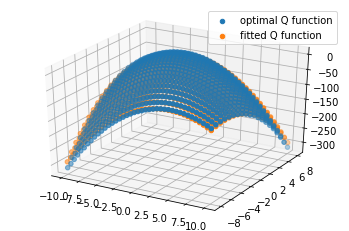

In [14]:
# Feature map
feature_map = LQG_FeatureFunction(env)


# theta
theta = np.zeros(feature_map.feature_dim)

# FQI
n_it = 10 
Z = np.zeros((N_transitions,feature_map.feature_dim))
y = np.zeros((N_transitions,))
policy = RandomPolicy(actions)
data = collect_data(policy, env, N_transitions, horizon)
data_states, data_actions, data_next_states, data_rewards, done_flags = data
gamma = 0.9
lambd = 0
for it in range(n_it):
    # Compute matrix Z and targets y
    for nn in range(N_transitions):        
        #pass
        Z[nn, :] = feature_map.map(data_states[nn,:], data_actions[nn,:])
        val = []
        for a in actions :
            val.append(theta@feature_map.map(data_next_states[nn,:], a ))
        # if done_flags[nn]==1:
            # val = np.zeros(val)
        y [nn] = data_rewards[nn] + gamma*np.max(val)
    #t = Z.T@Z - np.eye(feature_map.feature_dim,feature_map.feature_dim)
    #print(t.shape)
    theta = np.linalg.inv(Z.T@Z + lambd*np.eye(feature_map.feature_dim))@Z.T@y
    # Solve least squares problem to update theta

# Plot solution
plot_solution(env, feature_map, states, actions, theta, gamma)

# Step 4: Execute the policy

Write a loop to run the learned policy for $m$ episodes and compute the total sum of rewards obtained.

In [11]:
print(theta)

## Evaluate greedy policy 
n_sim = 100 # number of simulations
rewards = np.zeros(n_sim)
for sim in range(n_sim):
    done = False
    state = env.reset()
    # run one episode
    for ii in range(horizon):
      q_function = [theta.dot(feature_map.map(state, a)) for a in actions]
      action = actions[np.argmax(q_function)]
      next_state, reward, done, _ = env.step(action)
      state = next_state 
      rewards[sim] += reward

print("mean reward of greedy policy wrt to Q(s, a) = ", rewards.mean())


## Evaluate random policy 
rewards_rand = np.zeros(n_sim)
for sim in range(n_sim):
    done = False
    state = env.reset()
    # run one episode
    for ii in range(horizon):
      action = env.action_space.sample()
      next_state, reward, done, _ = env.step(action)
      state = next_state 
      rewards_rand[sim] += reward

print("mean reward of random policy = ", rewards_rand.mean())

[-1.14713459 -1.18499155  0.06462342]
mean reward of greedy policy wrt to Q(s, a) =  -32.004500888911274
mean reward of random policy =  -4354.22917360778
